In [1]:
pip install ipympl ipyplot

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 1
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import ipyplot as plt2
import seaborn as sns
import pandas as pd

%aimport helper

# Labels
Each training and test example is assigned to one of the following labels:

| Label |	Description  |
|-------|----------------|
|   0   |	T-shirt/top  |
|   1   |	Trouser      |
|   2   |	Pullover     |
|   3   |	Dress        |
|   4   |	Coat         |
|   5   |	Sandal       |
|   6   |	Shirt        |
|   7   |	Sneaker      |
|   8   |	Bag          |
|   9   |	Ankle boot   |


# EDA

## Dataset sample viewing

In [3]:
raw_x = np.load("./data/train/train_images.npy")
raw_y = pd.read_csv("./data/train/train_labels.csv")
label2txt = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
txtlabels = [label2txt[i] for i in raw_y["label"]]
plt2.plot_class_tabs(raw_x, txtlabels, img_width=28, show_url=False, zoom_scale=3)

## Classes mean element vector

In [4]:
class_mean_x = [np.mean(raw_x[raw_y["label"]==i], (0)) for i in range(10)]
plt2.plot_images(class_mean_x)

## Per Class pixel intensity histogram

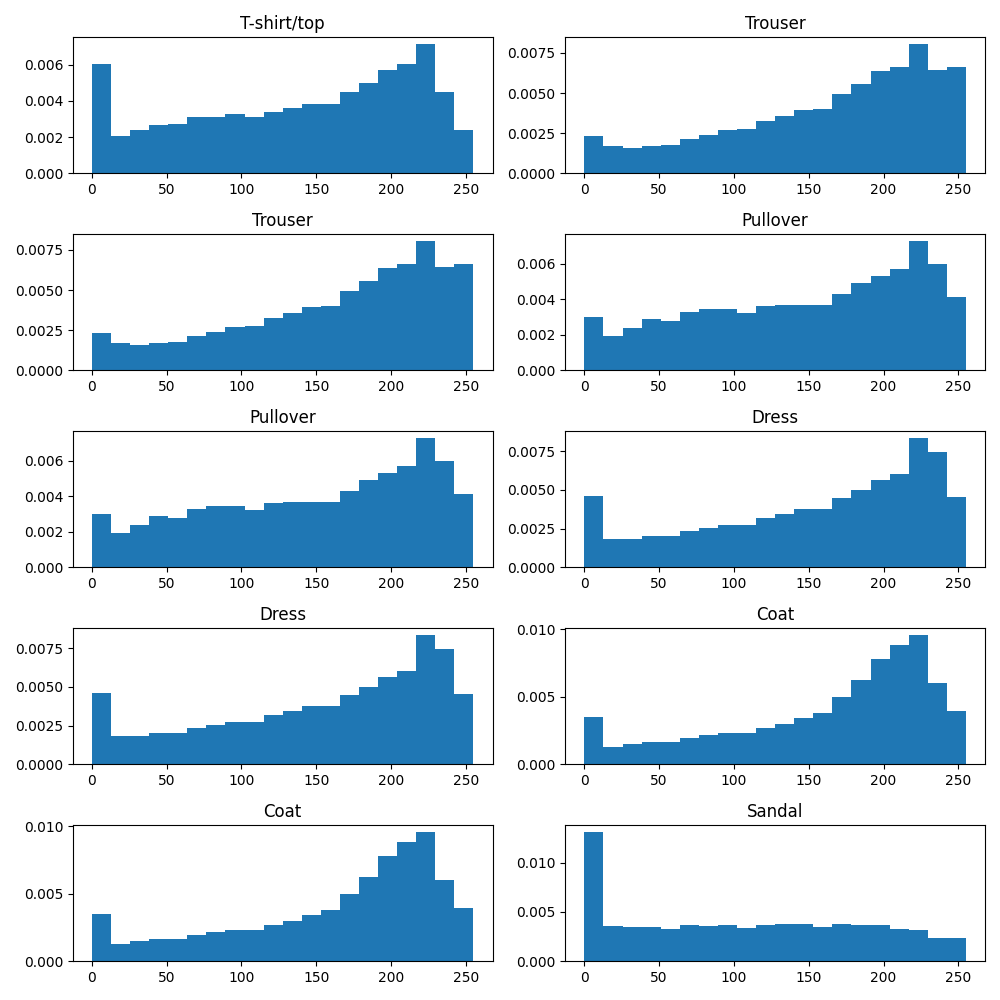

In [5]:
fig, axes = plt.subplots(5, 2, )
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_tight_layout(True)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i, j].hist(raw_x[raw_y["label"]==(i+j)].flatten(), bins=20, density=True, range=(0.1, 255))
        axes[i,j].set_title(label2txt[i+j])
        
plt.show()

## PCA Analisys

In [6]:
import sklearn.decomposition as dec

In [7]:
mean_x = np.mean(class_mean_x, 0)
mean_norm_x = raw_x - [mean_x for i in range(len(raw_x))]
flatten_x = np.array([img.flatten() for img in raw_x])

In [8]:
PCA_x = dec.PCA(n_components=3).fit_transform(flatten_x)
pca_df = pd.DataFrame.copy(raw_y)
pca_df["first dim"] = PCA_x[..., 0]
pca_df["second dim"] = PCA_x[..., 1]
pca_df["third dim"] = PCA_x[..., 2]
pca_df["txtlabel"] = txtlabels
pca_df

,label,first dim,second dim,third dim,txtlabel
0,9,-123.993791,1633.074396,-1211.041197,Ankle boot
1,0,1407.928853,-451.641336,-261.027156,T-shirt/top
2,0,-725.910795,-1101.838138,106.154318,T-shirt/top
3,3,31.398664,-981.067672,202.580959,Dress
4,0,804.119258,-1201.168720,-744.377189,T-shirt/top
...,...,...,...,...,...
59995,5,-1725.093422,-41.582509,324.750784,Sandal
59996,1,-27.515977,-1454.424893,-455.664428,Trouser
59997,3,857.750196,-1180.240183,-520.693665,Dress
59998,0,-807.476526,-581.218873,480.319853,T-shirt/top


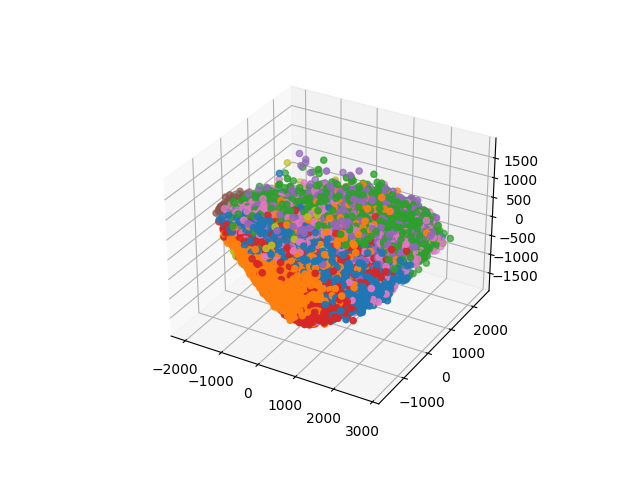

In [9]:
pca_3d_scatter = plt.figure()
ax = pca_3d_scatter.add_subplot(projection='3d')

ax.scatter3D(
    xs=pca_df["first dim"], ys=pca_df["second dim"], zs=pca_df["third dim"],
    c=pca_df["label"], 
    cmap='tab10',   
)
plt.show()

## t-SNE analisys

In [10]:
import sklearn.manifold as mf

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2007ad35b0>
Traceback (most recent call last):
  File "/home/gullino18/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/gullino18/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/gullino18/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/gullino18/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 2.460s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 455.672474
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.505234
[t-SNE] KL divergence after 1000 iterations: 1.514311


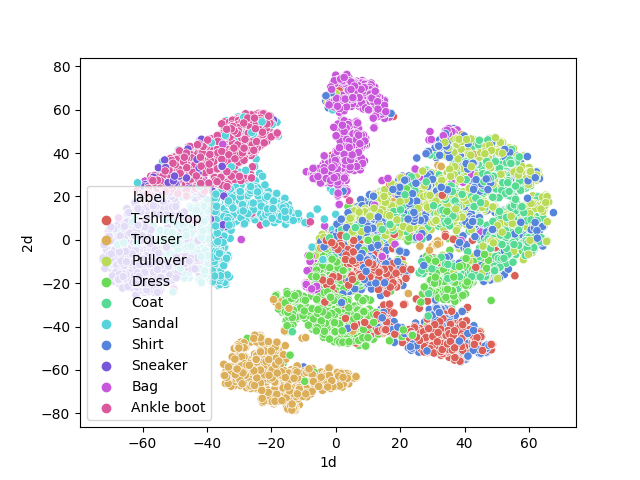

In [11]:
tsne_x = mf.TSNE(n_components=2, verbose=1, perplexity=40).fit_transform(flatten_x[:10000])

tsne_df = pd.DataFrame()
tsne_df["label"] = txtlabels[:10000]
tsne_df["1d"] = tsne_x[..., 0]
tsne_df["2d"] = tsne_x[..., 1]

plt.figure()
sns.scatterplot(
    x="1d", y="2d",
    hue="label",
    hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("hls", 10),
    data=tsne_df,

)
plt.show()

# Entrenamiento de modelos:


In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Sequential
import tensorflow as tf

metrics=['accuracy', 'AUC', precision_score, recall_score, f1_score]

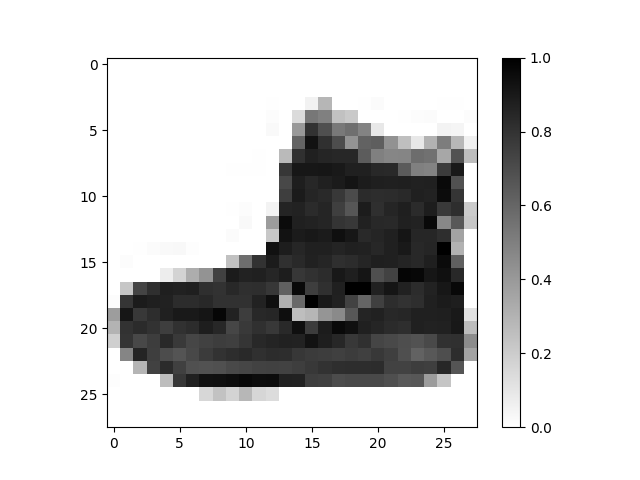

In [13]:
casted_x = np.array(raw_x, dtype="float32")
normalized_x = casted_x / 255
plt.figure()
plt.imshow(normalized_x[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [14]:
train_y = np.zeros([60000, 10])

for i in range(60000):
  train_y[i, raw_y["label"][i]] = 1


## Simple Softmax models

### Categorical Crossentropy

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0)
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=metrics[0:2])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(x=normalized_x, y=train_y, batch_size=32, epochs=100, validation_split=0.05, callbacks=[callback])

Epoch 1/100
1782/1782 [==============================] - 2s 712us/step - loss: 0.8412 - accuracy: 0.7318 - auc: 0.9674 - val_loss: 0.6212 - val_accuracy: 0.8010 - val_auc: 0.9810
Epoch 2/100
1782/1782 [==============================] - 1s 629us/step - loss: 0.5987 - accuracy: 0.8056 - auc: 0.9811 - val_loss: 0.5612 - val_accuracy: 0.8140 - val_auc: 0.9834
Epoch 3/100
1782/1782 [==============================] - 1s 646us/step - loss: 0.5476 - accuracy: 0.8210 - auc: 0.9835 - val_loss: 0.5146 - val_accuracy: 0.8260 - val_auc: 0.9857
Epoch 4/100
1782/1782 [==============================] - 1s 652us/step - loss: 0.5206 - accuracy: 0.8278 - auc: 0.9847 - val_loss: 0.4916 - val_accuracy: 0.8330 - val_auc: 0.9866
Epoch 5/100
1782/1782 [==============================] - 1s 642us/step - loss: 0.5025 - accuracy: 0.8335 - auc: 0.9855 - val_loss: 0.4744 - val_accuracy: 0.8330 - val_auc: 0.9874
Epoch 6/100
1782/1782 [==============================] - 1s 644us/step - loss: 0.4899 - accuracy: 0.8357 